In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

np.set_printoptions(suppress=True, precision =4)

In [2]:
class Relu_Knot_Net_Sequential():
    def __init__(self, hidden_layer = 1, batch_size = 100, training_epochs = 1000, learning_rate= 0.01):
        # Parameter initiation
        self.hidden_layer = 1
        self.batch_size = batch_size
        self.training_epochs = training_epochs
        self.learning_rate= learning_rate
        # clear previous graph
        tf.reset_default_graph()
        # Network Defination
        self.X = tf.placeholder("float")
        self.Y = tf.placeholder("float")
        self.hidden_layer = hidden_layer
        self.training_layer = 0
        self.create_deep_net()
            
    def create_deep_net(self):
        self.hs = []
        self.bs = []
        self.bs_upper_init = []
        self.bs_upper = []
        
        def re_split(inputs, upper_b, bs_upper_init, layer_name, trainable = True): 
            hs = []
            bs = []
            bs_upper = []
            new_bs_upper_init = []
            with tf.variable_scope(layer_name, reuse=tf.AUTO_REUSE):
                for i, node in enumerate(inputs):
                    bias = tf.get_variable(name = str(i+1), initializer = bs_upper_init[i]/2,\
                                       constraint = lambda x: tf.clip_by_value(x, 0, upper_b[i]), trainable = trainable)  
                    hs.extend([tf.nn.relu(node - bias), tf.nn.relu(-node + bias)])
                    bs.extend([bias])
                    bs_upper.extend([upper_b[i]-bias, bias])
                    new_bs_upper_init.extend([bs_upper_init[i] - bias.initialized_value(), bias.initialized_value()])
            return hs, bs, bs_upper, new_bs_upper_init

        with tf.variable_scope("Hierachical_ReluNet", reuse=tf.AUTO_REUSE):
            # hidden layer        
            h0, b0, b0_upper, b0_upper_init = re_split([self.X], tf.constant([1.0]), tf.constant([1.0]), 
                                                       layer_name = "L1", trainable = True)
            self.bs.append(b0)
            self.hs.append(tf.reshape(tf.transpose(h0, perm=[1, 0, 2]), [-1,2**1]))
            self.bs_upper_init.append(tf.constant([1.0]))
            self.bs_upper_init.append(b0_upper_init)
            self.bs_upper.append(b0_upper)
            
            self.output_list = [] 
            self.cost_list = [] 
            self.train_op_list = []
            self.WOut = tf.get_variable(name = "L1_Wout", initializer = tf.random_normal([2**1, 1], 0, 0.01))
            self.bOut = tf.get_variable(name = "L1_bout", initializer = tf.constant(0.0, shape=[1]))
            self.output_list.append(tf.matmul(self.hs[0], self.WOut) + self.bOut)    
            self.cost_list.append(tf.reduce_mean(tf.square(self.Y - self.output_list[-1])))
            self.train_op_list.append(tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost_list[-1], \
                                     var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "Hierachical_ReluNet/L"+str(1))))
            for i in range(self.hidden_layer-1):
                new_h, new_b, new_b_upper, new_b_upper_init = re_split(h0, b0_upper, b0_upper_init, layer_name = "L"+str(i+2))
                h0 = new_h; b0 = new_b; b0_upper = new_b_upper; b0_upper_init=new_b_upper_init
                self.bs.append(new_b)
                self.hs.append(tf.reshape(tf.transpose(new_h, perm=[1, 0, 2]), [-1,2**(i+2)]))
                self.bs_upper_init.append(b0_upper_init)
                self.bs_upper.append(b0_upper)
                
                self.WOut = tf.get_variable(name = "L"+str(i+2)+"_Wout", initializer = tf.random_normal([2**(i+2), 1], 0, 0.01))
                self.bOut = tf.get_variable(name = "L"+str(i+2)+"_bout", initializer = tf.constant(0.0, shape=[1]))
                self.output_list.append(tf.matmul(self.hs[-1], self.WOut) + self.bOut)
                self.cost_list.append(tf.reduce_mean(tf.square(self.Y - self.output_list[-1])))
                self.train_op_list.append(tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost_list[-1], \
                                     var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "Hierachical_ReluNet/L"+str(i+2))))
            # optimization
            # initilize
            self.sess = tf.Session()
            self.init_op = tf.group(
                    tf.local_variables_initializer(),
                    tf.global_variables_initializer()
                    )
            self.sess.run(self.init_op)
            all_bs = self.sess.run([self.bs])
            print("The initial knots.\n")
            for i in range(len(all_bs[0])):
                print("The " + str(i+1) +" Layer Knots:",np.round(np.hstack(all_bs[0][i]),3))
            print("\n")

    def train(self, train_x, train_y, training_layer = 0):
        self.err_train = []
        self.training_layer = training_layer
        train_size = train_x.shape[0]
        training_data = np.hstack([train_x,train_y])
        mini_batches = [training_data[k:k+self.batch_size] for k in range(0, train_size, self.batch_size)]
        for epoch in range(self.training_epochs):
            for i in range(len(mini_batches)):
                self.sess.run(self.train_op_list[self.training_layer], feed_dict={self.X: mini_batches[i][:,:1], self.Y: mini_batches[i][:,1:]})
            if (epoch + 1) % 500 == 0:
                err_train = self.sess.run(self.cost_list[self.training_layer], feed_dict={self.X: train_x, self.Y: train_y})
                self.err_train.append(err_train)
                print("Epoch ", epoch + 1, " Loss:", err_train)
        pred_train = self.sess.run(self.output_list[self.training_layer], feed_dict={self.X: train_x, self.Y: train_y})
        return pred_train 
        
    def predict(self, test_x):
        for i in range(self.hidden_layer):
            print("The " + str(i+1) +" Layer:",np.round(self.sess.run(self.hs[i], feed_dict={self.X: test_x}),3))
        pred = self.sess.run([self.output_list[self.training_layer]], feed_dict={self.X: test_x})
        print("The Final Output:",pred)
        return pred
    
    def get_knots(self):
        all_bs = self.sess.run(self.bs)
        b = [all_bs[0][0]]
        sign_init = [1]
        all_knots = b
        for i in range(self.training_layer):
            bb= []; sign = []
            for j in range(len(b)):
                sign.extend([sign_init[j], -sign_init[j]])
                bb.extend([b[j]+all_bs[i+1][2*j+0]*sign[2*j+0],b[j]+all_bs[i+1][2*j+1]*sign[2*j+1]])
            b = bb; sign_init = sign
            all_knots.extend(bb)
        return np.sort(all_knots)
    
    def evaluate(self, true_signal, pred_signal, true_knots, train_size):
        # mse
        mse = np.mean((true_signal - pred_signal)**2)
        # knots
        true_knots = np.array(true_knots)
        true_knot_number = len(true_knots)
        pred_knots = np.sort(np.unique(np.round(self.get_knots()*train_size)))
        pred_knot_number = len(pred_knots)
        diff_knot_number = pred_knot_number - true_knot_number
        # hausdorff
        temp1 = []; temp2 = []
        for i in range(true_knot_number):
            temp1.append(min(abs(true_knots[i] - pred_knots)))
        d1 = max(temp1)    
        for i in range(pred_knot_number):
            temp2.append(min(abs(pred_knots[i] - true_knots)))
        d2 = max(temp2)
        hausdorff = max(d1,d2)/len(true_signal)
        print("MSE:",np.round(mse, 4))
        print("The difference of knots:", diff_knot_number)
        print("The hausdorff distance:", np.round(hausdorff, 4))

    def summary(self, train_x, noise_signal, true_signal=None, scaler = None, true_knots = []):  
        train_size = len(noise_signal)
        x_label = train_x*train_size
        
        all_bs = self.sess.run([self.bs])

        all_knots = np.unique(np.round(self.get_knots()*train_size))
        knots_ls = np.array(all_knots)[(np.array(all_knots)>0)&(np.array(all_knots)<train_size)]
        print("Unique Knots:", knots_ls)
        # Prediction 
 
        if (true_signal is not None) & (scaler is not None):
            pred_signal = scaler.inverse_transform(self.sess.run(self.output_list[self.training_layer] , feed_dict={self.X: train_x})) 
            
            # Plot
            plt.figure(figsize=(10,4))
            plt.plot(x_label,noise_signal)
            plt.plot(x_label,pred_signal, c="red")
            plt.plot(x_label,true_signal, dashes=[6, 2], c="black")
            plt.scatter(knots_ls, np.min(noise_signal) - 0.1*np.ones(len(knots_ls)), color = "green")
            plt.legend(["Observed","Pred","True", "Knots"])
            
            # Evaluate
            if (len(true_knots) >0): 
                self.evaluate(true_signal, pred_signal, true_knots, train_size)

# Multiple Layer Piece wise RELU

## 1. Wave1

In [3]:
DataNum = 1408
wave1 = np.zeros([DataNum, 1])
intercept = 1
tau = [1, 256, 512, 768, 1024, 1152, 1280, 1344, 1408]
init_slope = 2**(-8)
slope = [0, 1*2**(-6), -2*2**(-6), 3*2**(-6), -4*2**(-6), 5*2**(-6), -6*2**(-6), 7*2**(-6)]
wave1[0] = intercept
for i in range(8):
    wave1[tau[i]:tau[i+1], 0] = wave1[tau[i]-1] + (init_slope - sum(slope[0:i+1])) * np.array(range(1,tau[i+1]-tau[i]+1))
    
wave1_noise = wave1 + np.random.normal(0,1,DataNum).reshape([-1,1])

scaler = MinMaxScaler()
train_x = np.reshape(np.linspace(1, DataNum, DataNum)/DataNum, [-1,1])
train_y = scaler.fit_transform(wave1_noise)

The initial knots.

The 1 Layer Knots: [0.5]
The 2 Layer Knots: [0.25 0.25]
The 3 Layer Knots: [0.125 0.125 0.125 0.125]
The 4 Layer Knots: [0.062 0.062 0.062 0.062 0.062 0.062 0.062 0.062]


Epoch  500  Loss: 0.017205546
Epoch  1000  Loss: 0.017205333
Epoch  1500  Loss: 0.017205112
Epoch  2000  Loss: 0.01720482
Epoch  2500  Loss: 0.017204707
Epoch  3000  Loss: 0.017204696
Epoch  3500  Loss: 0.017204696
Epoch  4000  Loss: 0.01720459
Epoch  4500  Loss: 0.01720461
Epoch  5000  Loss: 0.017204592
Unique Knots: [778.]
MSE: 1.5557
The difference of knots: -6
The hausdorff distance: 0.402


[[0.5528546],
 [0.25, 0.25],
 [0.125, 0.125, 0.125, 0.125],
 [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]]

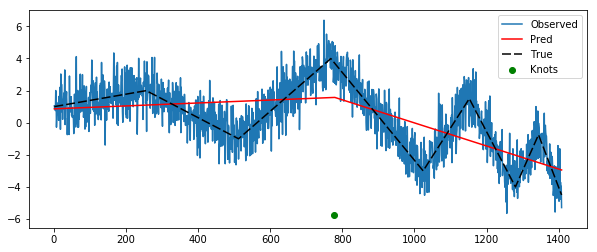

In [4]:
model = Relu_Knot_Net_Sequential(hidden_layer = 4, batch_size = 500, training_epochs = 5000, learning_rate= 0.01)
pred_train = model.train(train_x, train_y, 0)
model.summary(train_x, wave1_noise, wave1, scaler, [256, 512, 768, 1024, 1152, 1280, 1344])
all_bs = model.sess.run(model.bs)
all_bs

Epoch  500  Loss: 0.015142387
Epoch  1000  Loss: 0.015020441
Epoch  1500  Loss: 0.015019819
Epoch  2000  Loss: 0.015020267
Epoch  2500  Loss: 0.0150208585
Epoch  3000  Loss: 0.015020952
Epoch  3500  Loss: 0.015020919
Epoch  4000  Loss: 0.015020826
Epoch  4500  Loss: 0.015020896
Epoch  5000  Loss: 0.015020883
Unique Knots: [511. 778.]
MSE: 1.2193
The difference of knots: -4
The hausdorff distance: 0.1825


[[0.5528546],
 [0.44815302, 0.1898115],
 [0.125, 0.125, 0.125, 0.125],
 [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]]

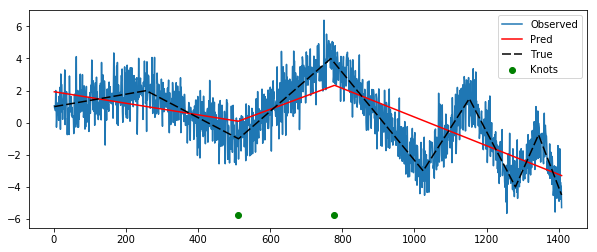

In [5]:
pred_train = model.train(train_x, train_y, 1)
model.summary(train_x, wave1_noise, wave1, scaler, [256, 512, 768, 1024, 1152, 1280, 1344])
all_bs = model.sess.run(model.bs)
all_bs

Epoch  500  Loss: 0.01447978
Epoch  1000  Loss: 0.014167524
Epoch  1500  Loss: 0.014082979
Epoch  2000  Loss: 0.014027693
Epoch  2500  Loss: 0.014095529
Epoch  3000  Loss: 0.013972328
Epoch  3500  Loss: 0.013882076
Epoch  4000  Loss: 0.013861361
Epoch  4500  Loss: 0.013866612
Epoch  5000  Loss: 0.013848206
Unique Knots: [ 511.  757.  778. 1373.]
MSE: 1.0332
The difference of knots: -2
The hausdorff distance: 0.1811


[[0.5528546],
 [0.44815302, 0.1898115],
 [0.0, 0.02564096, 0.0, 0.17491078],
 [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]]

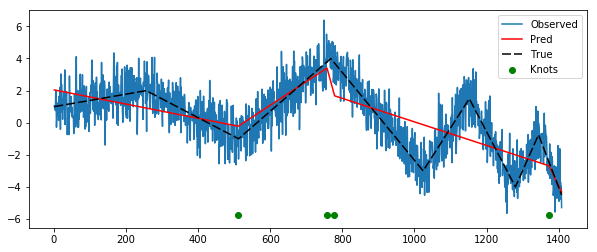

In [6]:
pred_train = model.train(train_x, train_y, 2)
model.summary(train_x, wave1_noise, wave1, scaler, [256, 512, 768, 1024, 1152, 1280, 1344])
all_bs = model.sess.run(model.bs)
all_bs

Epoch  500  Loss: 0.014557224
Epoch  1000  Loss: 0.014418694
Epoch  1500  Loss: 0.014320803
Epoch  2000  Loss: 0.014242351
Epoch  2500  Loss: 0.01418649
Epoch  3000  Loss: 0.014125932
Epoch  3500  Loss: 0.01407047
Epoch  4000  Loss: 0.013601553
Epoch  4500  Loss: 0.013568875
Epoch  5000  Loss: 0.0135537
Unique Knots: [ 511.  754.  757.  778.  799. 1289. 1373.]
MSE: 0.992
The difference of knots: 1
The hausdorff distance: 0.1811


[[0.5528546],
 [0.44815302, 0.1898115],
 [0.0, 0.02564096, 0.0, 0.17491078],
 [0.0, 0.0, 0.059550785, 0.0, 0.0, 0.0, 0.029595984, 0.0027269984]]

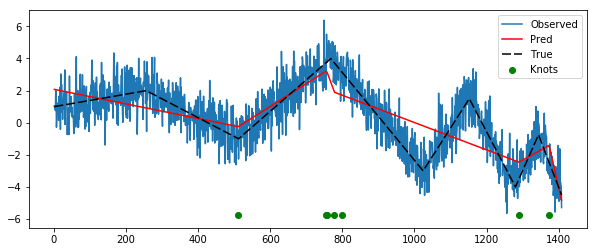

In [7]:
pred_train = model.train(train_x, train_y, 3)
model.summary(train_x, wave1_noise, wave1, scaler, [256, 512, 768, 1024, 1152, 1280, 1344])
all_bs = model.sess.run(model.bs)
all_bs